# **Feature importance**

## Data and Model Import

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from utils import *


datasets_folder = './datasets'
models_folder = './models'
figsize = (20,4)
verbosity = 0

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = pollution_data.keys()

In [27]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
        # bin_size = 8,
        # offset = 2
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10


In [28]:
train_split_date = datetime(2023,12,31,23)
target = 'Agent_value'

training_sets = {}
test_sets = {}

for station in stations:
    training_sets[station] = {}
    test_sets[station] = {}
    for agent in station_data[station].keys():
        training_sets[station][agent] = {}
        test_sets[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent], train_split_date, y=target)

        training_sets[station][agent]['x'] = x_train
        training_sets[station][agent]['y'] = y_train
        test_sets[station][agent]['x'] = x_test
        test_sets[station][agent]['y'] = y_test

In [5]:
models = load_models(models_folder)

Loading model: GIARDINI MARGHERITA.NO2
Loading model: GIARDINI MARGHERITA.O3
Loading model: GIARDINI MARGHERITA.PM10.pkl
Loading model: GIARDINI MARGHERITA.PM2_5
Loading model: PORTA SAN FELICE.C6H6
Loading model: PORTA SAN FELICE.CO
Loading model: PORTA SAN FELICE.NO2
Loading model: PORTA SAN FELICE.PM10
Loading model: PORTA SAN FELICE.PM2_5
Loading model: VIA CHIARINI.NO2
Loading model: VIA CHIARINI.O3
Loading model: VIA CHIARINI.PM10


## Explainability with SHAP

In [6]:
import shap

agents_shap_values = {}

### Three based models

si potrebbe anchemettere sotto, solo che questo è immediato anche con tanti campioni, quelli sotto sono iper lenti

Shap summary of the RandomForestRegressor used for PM10 in GIARDINI MARGHERITA:


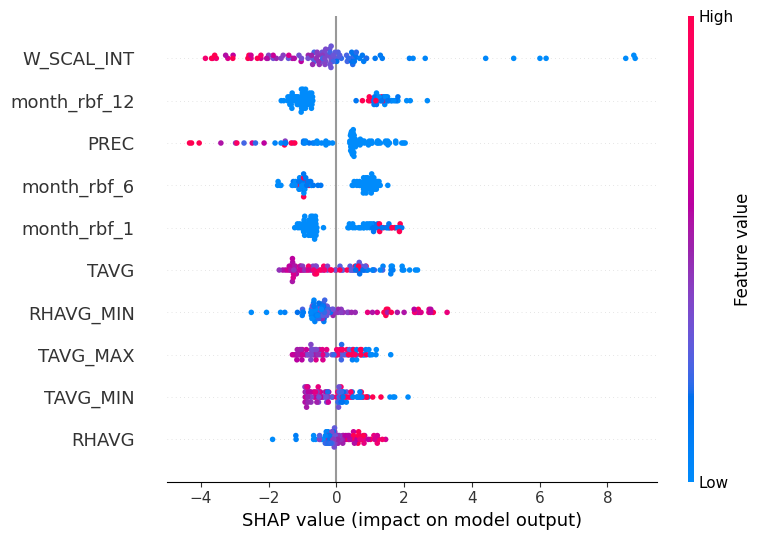

In [7]:
shap_samples = 100

for station in stations:
    if station not in agents_shap_values:
        agents_shap_values[station] = {}
    for agent in models[station].keys():
        model = models[station][agent]
        if isinstance(model, RandomForestRegressor):
            print(f'Shap summary of the RandomForestRegressor used for {agent} in {station}:')
            explainer = shap.TreeExplainer(model)
            test_data = test_sets[station][agent]['x'].sample(shap_samples, random_state=42)
            shap_values = explainer.shap_values(test_data)
            agents_shap_values[station][agent] = shap_values
            shap.summary_plot(shap_values, test_data, max_display=10)
            # shap.initjs()
            # shap.plots.force(explainer.expected_value, shap_values, X)

### Deep Machine Learning Models

Shap summary of the model used for NO2 in GIARDINI MARGHERITA:


Exception ignored in: <function tqdm.__del__ at 0x0000021658AB5E10>
Traceback (most recent call last):
  File "c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'
c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
C:\Users\Davide\AppData\Local\Temp\ipykernel_18704\758547261.py:40: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use t

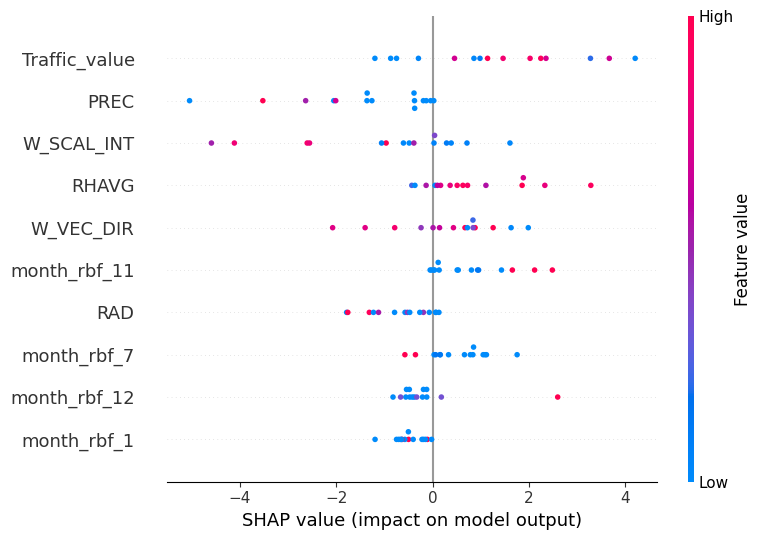

Shap summary of the model used for O3 in GIARDINI MARGHERITA:


c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
C:\Users\Davide\AppData\Local\Temp\ipykernel_18704\758547261.py:40: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, pd.DataFrame(test_data.mean(axis=1), columns=test_sets[station][agent]['x'].columns), max_display=10)


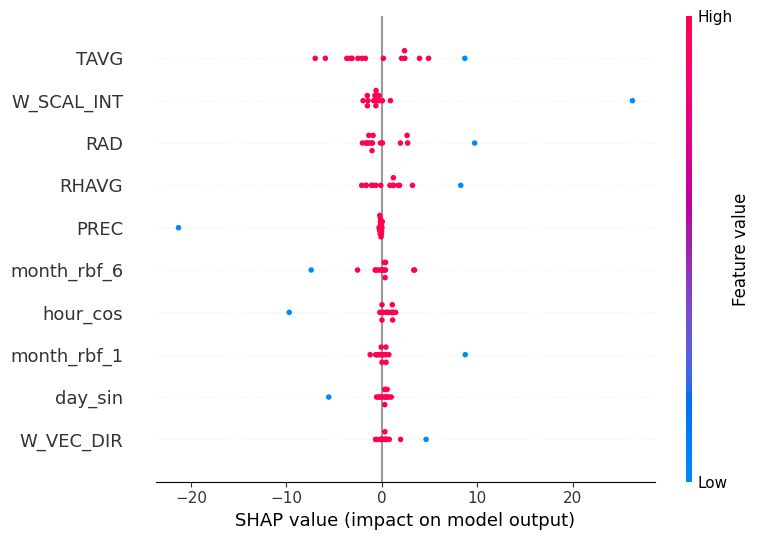

Shap summary of the model used for PM2.5 in GIARDINI MARGHERITA:


  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\Davide\AppData\Local\Temp\ipykernel_18704\758547261.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_data, max_display=10)


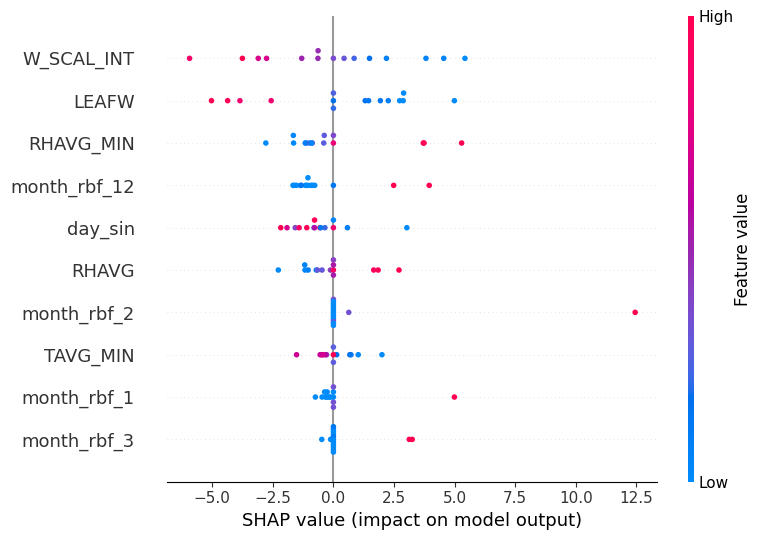

Shap summary of the model used for C6H6 in PORTA SAN FELICE:


c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
C:\Users\Davide\AppData\Local\Temp\ipykernel_18704\758547261.py:40: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, pd.DataFrame(test_data.mean(axis=1), columns=test_sets[station][agent]['x'].columns), max_display=10)


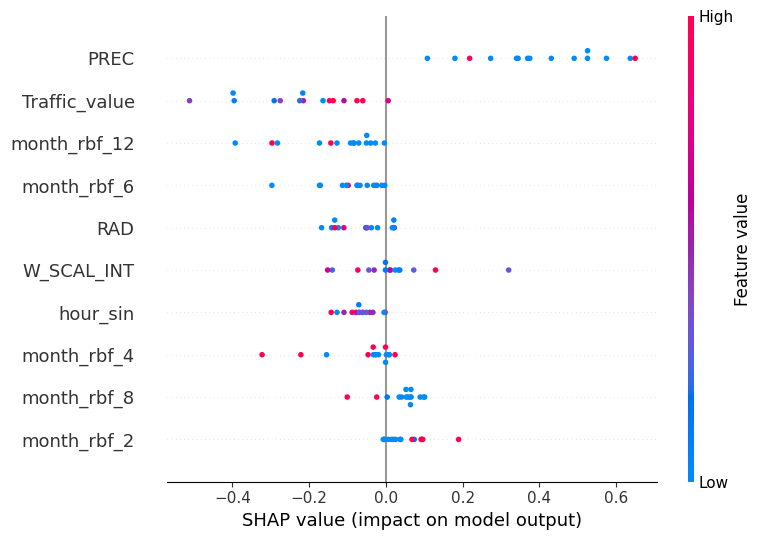

Shap summary of the model used for CO in PORTA SAN FELICE:


  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\Davide\AppData\Local\Temp\ipykernel_18704\758547261.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_data, max_display=10)


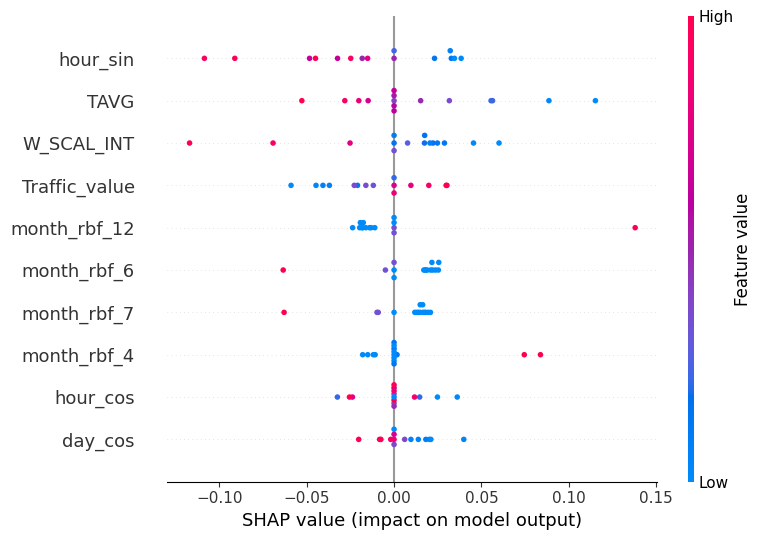

Shap summary of the model used for NO2 in PORTA SAN FELICE:


c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
C:\Users\Davide\AppData\Local\Temp\ipykernel_18704\758547261.py:40: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, pd.DataFrame(test_data.mean(axis=1), columns=test_sets[station][agent]['x'].columns), max_display=10)


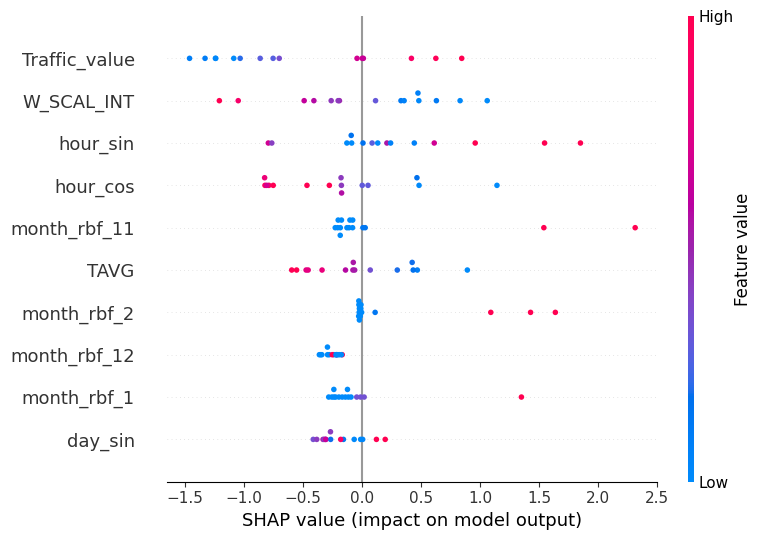

Shap summary of the model used for PM10 in PORTA SAN FELICE:


  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\Davide\AppData\Local\Temp\ipykernel_18704\758547261.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_data, max_display=10)


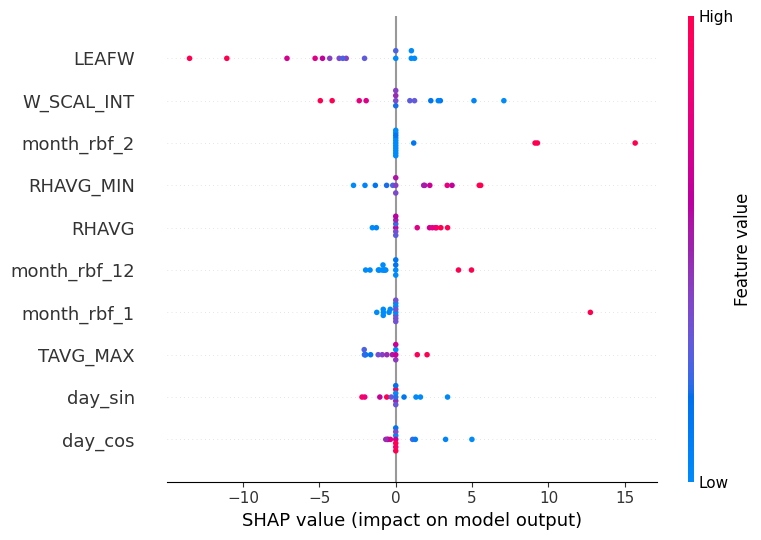

Shap summary of the model used for PM2.5 in PORTA SAN FELICE:


  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\Davide\AppData\Local\Temp\ipykernel_18704\758547261.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_data, max_display=10)


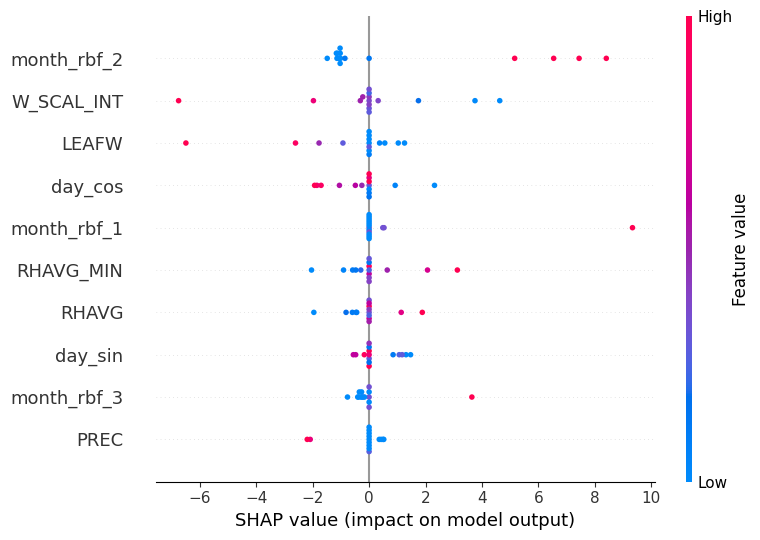

Shap summary of the model used for NO2 in VIA CHIARINI:


  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\Davide\AppData\Local\Temp\ipykernel_18704\758547261.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_data, max_display=10)


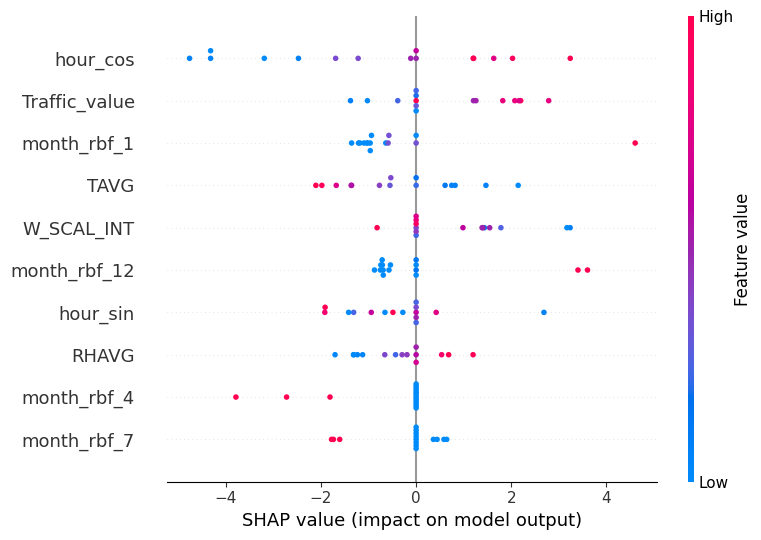

Shap summary of the model used for O3 in VIA CHIARINI:


c:\Users\Davide\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
C:\Users\Davide\AppData\Local\Temp\ipykernel_18704\758547261.py:40: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, pd.DataFrame(test_data.mean(axis=1), columns=test_sets[station][agent]['x'].columns), max_display=10)


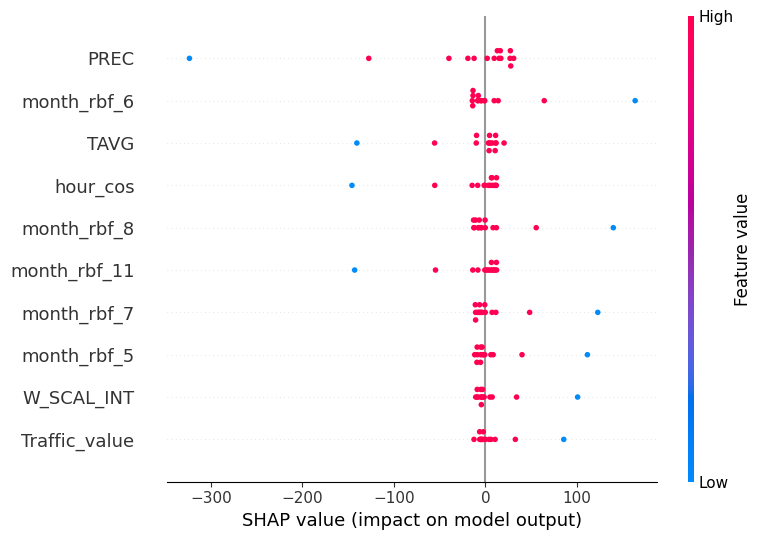

Shap summary of the model used for PM10 in VIA CHIARINI:


  0%|          | 0/15 [00:00<?, ?it/s]

C:\Users\Davide\AppData\Local\Temp\ipykernel_18704\758547261.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, test_data, max_display=10)


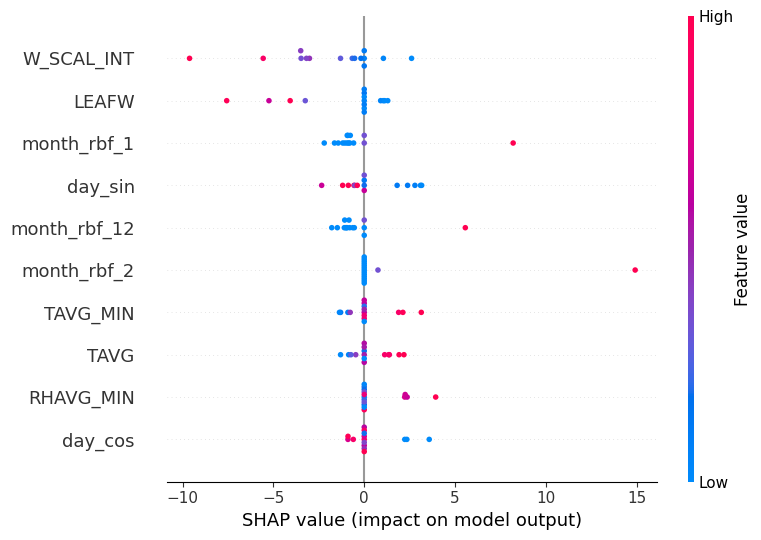

In [ ]:
def model_predict(data):
    return model.predict(data,
                  verbose=0
                  ).reshape(-1)


shap_samples = 15

for station in stations:
    if station not in agents_shap_values:
        agents_shap_values[station] = {}
    for agent in models[station].keys():
        model = models[station][agent]
        if isinstance(model, tf.keras.models.Sequential):
            print(f'Shap summary of the model used for {agent} in {station}:')
            training_data = None
            test_data = None
            explainer = None
            shap_values = None
            input_shape = model.input_shape
            if len(input_shape) == 2: # ffnn
                # continue
                training_data = training_sets[station][agent]['x'].sample(shap_samples, random_state=42)
                test_data = test_sets[station][agent]['x'].sample(shap_samples, random_state=42)
                explainer = shap.KernelExplainer(model_predict, training_data)
                # explainer = shap.DeepExplainer(model, training_data)
                shap_values = explainer.shap_values(test_data)
                agents_shap_values[station][agent] = shap_values
                shap.summary_plot(shap_values, test_data, max_display=10)
            elif len(input_shape) == 3: # lstm
                # continue
                ts = input_shape[1] 
                use_mask = isinstance(model.layers[0], tf.keras.layers.Masking)
                training_data, _ = create_sequences(training_sets[station][agent]['x'], training_sets[station][agent]['y'], ts, use_mask=use_mask)
                test_data, _ = create_sequences(test_sets[station][agent]['x'], test_sets[station][agent]['y'], ts, use_mask=use_mask)
                training_data_idx = np.random.choice(training_data.shape[0], size=shap_samples, replace=False)
                test_data_idx = np.random.choice(test_data.shape[0], size=shap_samples, replace=False)
                training_data = training_data[training_data_idx]
                test_data = test_data[test_data_idx]
                
                # deep or gradient
                explainer = shap.GradientExplainer(model, training_data)
                shap_values = explainer.shap_values(test_data)
                shap_values = np.mean(np.squeeze(shap_values), axis=1)
                agents_shap_values[station][agent] = shap_values
                shap.summary_plot(shap_values, pd.DataFrame(test_data.mean(axis=1), columns=test_sets[station][agent]['x'].columns), max_display=10)

                # kernel
                # explainer = shap.KernelExplainer(model_predict, training_data)
                # shap_values = explainer.shap_values(test_data.reshape(test_data.shape[0], -1))
                # shap_values = explainer.shap_values(test_data)

            else: continue

In [36]:
for station in stations:
    print(agents_shap_values[station].keys())

dict_keys(['PM10', 'NO2', 'O3', 'PM2.5'])
dict_keys(['C6H6', 'CO', 'NO2', 'PM10', 'PM2.5'])
dict_keys(['NO2', 'O3', 'PM10'])
